In [1]:
from copy import deepcopy

import cheetah
import lightning
import matplotlib.pyplot as plt
import numpy as np
import ocelot
import torch
from dataset import OcelotSpaceChargeQuadrupoleDataset
from icecream import ic
from matplotlib.patches import Ellipse
from models import SupervisedSpaceChargeQuadrupoleInference
from ocelot.adaptors.astra2ocelot import astraBeam2particleArray
from ocelot.cpbd.beam import generate_parray

[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.


initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation


In [2]:
plt.style.use(["science", "ieee", "no-latex"])

In [3]:
dataset_train_normalized = OcelotSpaceChargeQuadrupoleDataset(
    stage="train", use_logarithm=True, normalize=True
)

In [4]:
print("Incoming_scaler mean: ", dataset_train_normalized.incoming_scaler.mean_)
print("Incoming_scaler scale: ", dataset_train_normalized.incoming_scaler.scale_)
print("Controls_scaler mean: ", dataset_train_normalized.controls_scaler.mean_)
print("Controls_scaler scale: ", dataset_train_normalized.controls_scaler.scale_)
print("Outgoing_scaler mean: ", dataset_train_normalized.outgoing_delta_scaler.mean_)
print("Outgoing_scaler scale: ", dataset_train_normalized.outgoing_delta_scaler.scale_)

Incoming_scaler mean:  [ -9.16133653  -9.20506145  -9.15561984  -9.21447    -11.46046717
  -4.60464917 -23.62778504  17.49050901]
Incoming_scaler scale:  [1.33031134 1.32873058 1.33181537 1.33165291 2.00158023 0.00244901
 2.40783646 1.92626676]
Controls_scaler mean:  [ 0.27423374 -0.08668878]
Controls_scaler scale:  [ 0.12987194 41.49785937]
Outgoing_scaler mean:  [0.00085477 0.00528064 0.00084973 0.0052313  0.00020997 0.02189849]
Outgoing_scaler scale:  [0.00374061 0.02306732 0.00373912 0.02296184 0.00110329 0.05960068]


In [5]:
model = SupervisedSpaceChargeQuadrupoleInference.load_from_checkpoint(
    "space-charge-quadrupole/allgm5gt/checkpoints/epoch=91-step=345000.ckpt"  # Logarithmic input and data set
)
model.eval()

SupervisedSpaceChargeQuadrupoleInference(
  (net): SpaceChargeQuadrupoleMLP(
    (input_layer): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): Identity()
      (2): Tanh()
    )
    (hidden_net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Identity()
        (2): Tanh()
      )
    )
    (output_layer): Linear(in_features=256, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)

In [6]:
model.net

SpaceChargeQuadrupoleMLP(
  (input_layer): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): Identity()
    (2): Tanh()
  )
  (hidden_net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Identity()
      (2): Tanh()
    )
  )
  (output_layer): Linear(in_features=256, out_features=6, bias=True)
)

In [7]:
import torch


class NNSpaceChargeQuadrupole(cheetah.Quadrupole):
    """
    Neural network-based quadrupole with space charge.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Load trained neural network model
        model = SupervisedSpaceChargeQuadrupoleInference.load_from_checkpoint(
            # "space-charge-quadrupole/164q37d1/checkpoints/epoch=33-step=7990.ckpt"  # MSE
            # "space-charge-quadrupole/cbz8lcqk/checkpoints/epoch=147-step=34780.ckpt"  # Weighted MSE
            # "space-charge-quadrupole/ub6tzevg/checkpoints/epoch=63-step=12032.ckpt"  # Logarithmic input and data set
            # "space-charge-quadrupole/ghpd58x1/checkpoints/epoch=32-step=123750.ckpt"  # Logarithmic input and data set (large)
            "space-charge-quadrupole/allgm5gt/checkpoints/epoch=91-step=345000.ckpt"  # Logarithmic input and data set (large, tuned)
            # "space-charge-quadrupole/pe9nvh12/checkpoints/epoch=37-step=14250.ckpt"  # Logarithmic input and output
        )
        self._delta_predictor = model.cpu().eval()

        self._incoming_scaler_mean = (
            torch.from_numpy(dataset_train_normalized.incoming_scaler.mean_)
            .float()
            .cpu()
        )
        self._incoming_scaler_scale = (
            torch.from_numpy(dataset_train_normalized.incoming_scaler.scale_)
            .float()
            .cpu()
        )
        self._controls_scaler_mean = (
            torch.from_numpy(dataset_train_normalized.controls_scaler.mean_)
            .float()
            .cpu()
        )
        self._controls_scaler_scale = (
            torch.from_numpy(dataset_train_normalized.controls_scaler.scale_)
            .float()
            .cpu()
        )
        self._outgoing_delta_scaler_mean = (
            torch.from_numpy(dataset_train_normalized.outgoing_delta_scaler.mean_)
            .float()
            .cpu()
        )
        self._outgoing_delta_scaler_scale = (
            torch.from_numpy(dataset_train_normalized.outgoing_delta_scaler.scale_)
            .float()
            .cpu()
        )

    @property
    def is_skippable(self) -> bool:
        return False

    def track(self, incoming: cheetah.Beam) -> cheetah.Beam:
        """
        Track particles through the element Quadrupole while taking into account space
        charge using a neural network delta predictor.

        NOTE: This method currently only supports `ParameterBeam`s.

        :param incoming: Beam of particles entering the element.
        :return: Beam of particles exiting the element.
        """
        if isinstance(incoming, cheetah.ParameterBeam):
            tm = self.transfer_map(incoming.energy, incoming.species)
            mu = torch.matmul(tm, incoming.mu)
            cov = torch.matmul(tm, torch.matmul(incoming.cov, tm.t()))
            outgoing_without_space_charge = cheetah.ParameterBeam(
                mu,
                cov,
                incoming.energy,
                total_charge=incoming.total_charge,
                device=mu.device,
                dtype=mu.dtype,
            )

            return self._add_space_charge_delta(incoming, outgoing_without_space_charge)

        elif isinstance(incoming, cheetah.ParticleBeam):
            raise NotImplementedError(f"{type(self)} does not support ParticleBeam")
        else:
            raise TypeError(f"Parameter incoming is of invalid type {type(incoming)}")

    def _add_space_charge_delta(
        self,
        incoming: cheetah.ParameterBeam,
        outgoing_without_space_charge: cheetah.ParameterBeam,
    ) -> cheetah.ParameterBeam:
        """
        Take the normally (without space charge) tracked beam and modify it to take
        space charge effects into account.
        """
        # TODO: The following two currently break differentiability
        incoming_parameters = torch.tensor(
            [
                incoming.sigma_x,
                incoming.sigma_px,
                incoming.sigma_y,
                incoming.sigma_py,
                incoming.sigma_tau,
                incoming.sigma_p,
                incoming.total_charge,
                incoming.energy,
            ]
        ).cpu()
        controls = torch.tensor([self.length, self.k1]).cpu()

        # print(f"{incoming_parameters = }")

        incoming_parameters_log = torch.log(incoming_parameters)

        incoming_parameters_normalized = (
            incoming_parameters_log - self._incoming_scaler_mean
        ) / self._incoming_scaler_scale
        controls_normalized = (
            controls - self._controls_scaler_mean
        ) / self._controls_scaler_scale

        outgoing_delta_normalized = self._delta_predictor(
            incoming_parameters_normalized.unsqueeze(0),
            controls_normalized.unsqueeze(0),
        )[0]

        # print(f"{incoming_parameters_normalized.shape = }")
        # print(f"{incoming_parameters_normalized.unsqueeze(0).shape = }")
        # print(f"{controls_normalized.unsqueeze(0).shape = }")
        # print(
        #     f"{self._delta_predictor(incoming_parameters_normalized.unsqueeze(0), controls_normalized.unsqueeze(0)).shape = }"
        # )
        # print(f"{outgoing_delta_normalized.shape = }")

        outgoing_delta = (
            outgoing_delta_normalized * self._outgoing_delta_scaler_scale
            + self._outgoing_delta_scaler_mean
        )

        # print(f"{outgoing_without_space_charge.sigma_x = }")
        # print(f"{outgoing_delta[0] = }")
        # print(f"{outgoing_without_space_charge.sigma_x - outgoing_delta[0] = }")
        # print(f"{outgoing_without_space_charge.sigma_x + outgoing_delta[0] = }")

        outgoing_with_space_charge = outgoing_without_space_charge.transformed_to(
            sigma_x=outgoing_without_space_charge.sigma_x + outgoing_delta[0],
            sigma_px=outgoing_without_space_charge.sigma_px + outgoing_delta[1],
            sigma_y=outgoing_without_space_charge.sigma_y + outgoing_delta[2],
            sigma_py=outgoing_without_space_charge.sigma_py + outgoing_delta[3],
            sigma_tau=outgoing_without_space_charge.sigma_tau + outgoing_delta[4],
            sigma_p=outgoing_without_space_charge.sigma_p + outgoing_delta[5],
        )

        # print(f"{outgoing_with_space_charge.sigma_x = }")

        return outgoing_with_space_charge

In [8]:
cheetah_quadrupole = cheetah.Quadrupole(length=torch.tensor(0.12), k1=torch.tensor(7.2))

neural_quadrupole = NNSpaceChargeQuadrupole(
    length=torch.tensor(0.12), k1=torch.tensor(7.2)
)

In [9]:
incoming = cheetah.ParameterBeam.from_parameters(
    sigma_x=torch.tensor(1e-4),
    sigma_px=torch.tensor(1e-4),
    sigma_y=torch.tensor(1e-4),
    sigma_py=torch.tensor(1e-4),
    sigma_tau=torch.tensor(3e-5),
    sigma_p=torch.tensor(1e-4),
    total_charge=torch.tensor(1e-11),
    energy=torch.tensor(1e7),
)
print(f"{cheetah_quadrupole.track(incoming) = }")
print(f"{neural_quadrupole.track(incoming) = }")

cheetah_quadrupole.track(incoming) = ParameterBeam(mu=tensor([0., 0., 0., 0., 0., 0., 1.]), cov=tensor([[ 9.1376e-09, -6.9363e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-6.9363e-09,  1.6209e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.1222e-08,  1.0534e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0534e-08,  1.8800e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  9.0000e-10,
         -3.1416e-12,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -3.1416e-12,
          1.0000e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), energy=tensor(10000000.), total_charge=tensor(1.0000e-11), s=tensor(0.1200), species=Species(name='electron', num_elementary_charges

In [10]:
dataset_train_raw = OcelotSpaceChargeQuadrupoleDataset(
    stage="train", use_logarithm=False, normalize=False
)

In [11]:
energies = torch.linspace(1e6, 1e7, steps=30)
sample_idx = 5

In [12]:
p_array_incoming = generate_parray(
    sigma_x=dataset_train_raw[sample_idx][0][0][0].numpy(),
    sigma_px=dataset_train_raw[sample_idx][0][0][1].numpy(),
    sigma_y=dataset_train_raw[sample_idx][0][0][2].numpy(),
    sigma_py=dataset_train_raw[sample_idx][0][0][3].numpy(),
    sigma_tau=dataset_train_raw[sample_idx][0][0][4].numpy(),
    sigma_p=dataset_train_raw[sample_idx][0][0][5].numpy(),
    charge=1e-9,  # dataset_train_raw[sample_idx][0][0][6].numpy(),
    nparticles=100_000,
    energy=dataset_train_raw[sample_idx][0][0][7].numpy() * 1e-9,  # GeV
    chirp=0.0,
)
p_array_incoming.q_array = (
    np.full_like(p_array_incoming.q_array, 1e-9) / p_array_incoming.size()
)

# The marker is needed for space charge to work
ocelot_cell = [ocelot.Quadrupole(l=0.12, k1=7.2), ocelot.Marker("dummy")]

ocelot_space_charge_outgoings = []
for energy in energies:
    p_array_incoming.E = energy.item() * 1e-9

    # method = {"global": ocelot.SecondTM}
    method = {}
    lattice = ocelot.MagneticLattice(ocelot_cell, method=method)

    space_charge = ocelot.SpaceCharge()
    space_charge.nmesh_xyz = [63, 63, 63]
    space_charge.step = 1

    navigator = ocelot.Navigator(lattice)
    navigator.add_physics_proc(space_charge, ocelot_cell[0], ocelot_cell[-1])
    navigator.unit_step = 0.02

    p_array = deepcopy(p_array_incoming)
    _, p_array_outgoing = ocelot.track(lattice, p_array, navigator)

    ocelot_space_charge_outgoings.append(p_array_outgoing)

ocelot_simple_outgoings = []
for energy in energies:
    p_array_incoming.E = energy.item() * 1e-9

    lattice = ocelot.MagneticLattice(ocelot_cell)

    navigator = ocelot.Navigator(lattice)

    p_array = deepcopy(p_array_incoming)
    _, p_array_outgoing = ocelot.track(lattice, p_array, navigator)

    ocelot_simple_outgoings.append(p_array_outgoing)

z = 0.12 / 0.12. Applied: SpaceCharge

In [13]:
# Data set sample

# With space charge
p_array_incoming.E = 6197715.5 * 1e-9

# method = {"global": ocelot.SecondTM}
method = {}
lattice = ocelot.MagneticLattice(ocelot_cell, method=method)

space_charge = ocelot.SpaceCharge()
space_charge.nmesh_xyz = [63, 63, 63]
space_charge.step = 1

navigator = ocelot.Navigator(lattice)
navigator.add_physics_proc(space_charge, ocelot_cell[0], ocelot_cell[-1])
navigator.unit_step = 0.02

p_array = deepcopy(p_array_incoming)
_, p_array_outgoing_simple_62 = ocelot.track(lattice, p_array, navigator)

# Without space charge
p_array_incoming.E = 6197715.5 * 1e-9

lattice = ocelot.MagneticLattice(ocelot_cell)

navigator = ocelot.Navigator(lattice)

p_array = deepcopy(p_array_incoming)
_, p_array_outgoing_sc_62 = ocelot.track(lattice, p_array, navigator)

z = 0.12 / 0.12. Applied: SpaceCharge

In [14]:
# incoming = cheetah.ParameterBeam.from_ocelot(p_array_incoming)
incoming = cheetah.ParameterBeam.from_parameters(
    sigma_x=dataset_train_raw[sample_idx][0][0][0],
    sigma_px=dataset_train_raw[sample_idx][0][0][1],
    sigma_y=dataset_train_raw[sample_idx][0][0][2],
    sigma_py=dataset_train_raw[sample_idx][0][0][3],
    sigma_tau=dataset_train_raw[sample_idx][0][0][4],
    sigma_p=dataset_train_raw[sample_idx][0][0][5],
    total_charge=torch.tensor(1e-9),
    energy=dataset_train_raw[sample_idx][0][0][7],
)

cheetah_outgoings = []
neural_outgoings = []
for energy in energies:
    incoming = incoming.transformed_to(energy=energy)

    cheetah_outgoing = cheetah_quadrupole.track(incoming)
    neural_outgoing = neural_quadrupole.track(incoming)

    cheetah_outgoings.append(cheetah_outgoing)
    neural_outgoings.append(neural_outgoing)

In [15]:
# Data set sample
incoming_62 = incoming.transformed_to(energy=torch.tensor(6197715.5))
cheetah_outgoing_62 = cheetah_quadrupole.track(incoming)
neural_outgoing_62 = neural_quadrupole.track(incoming)

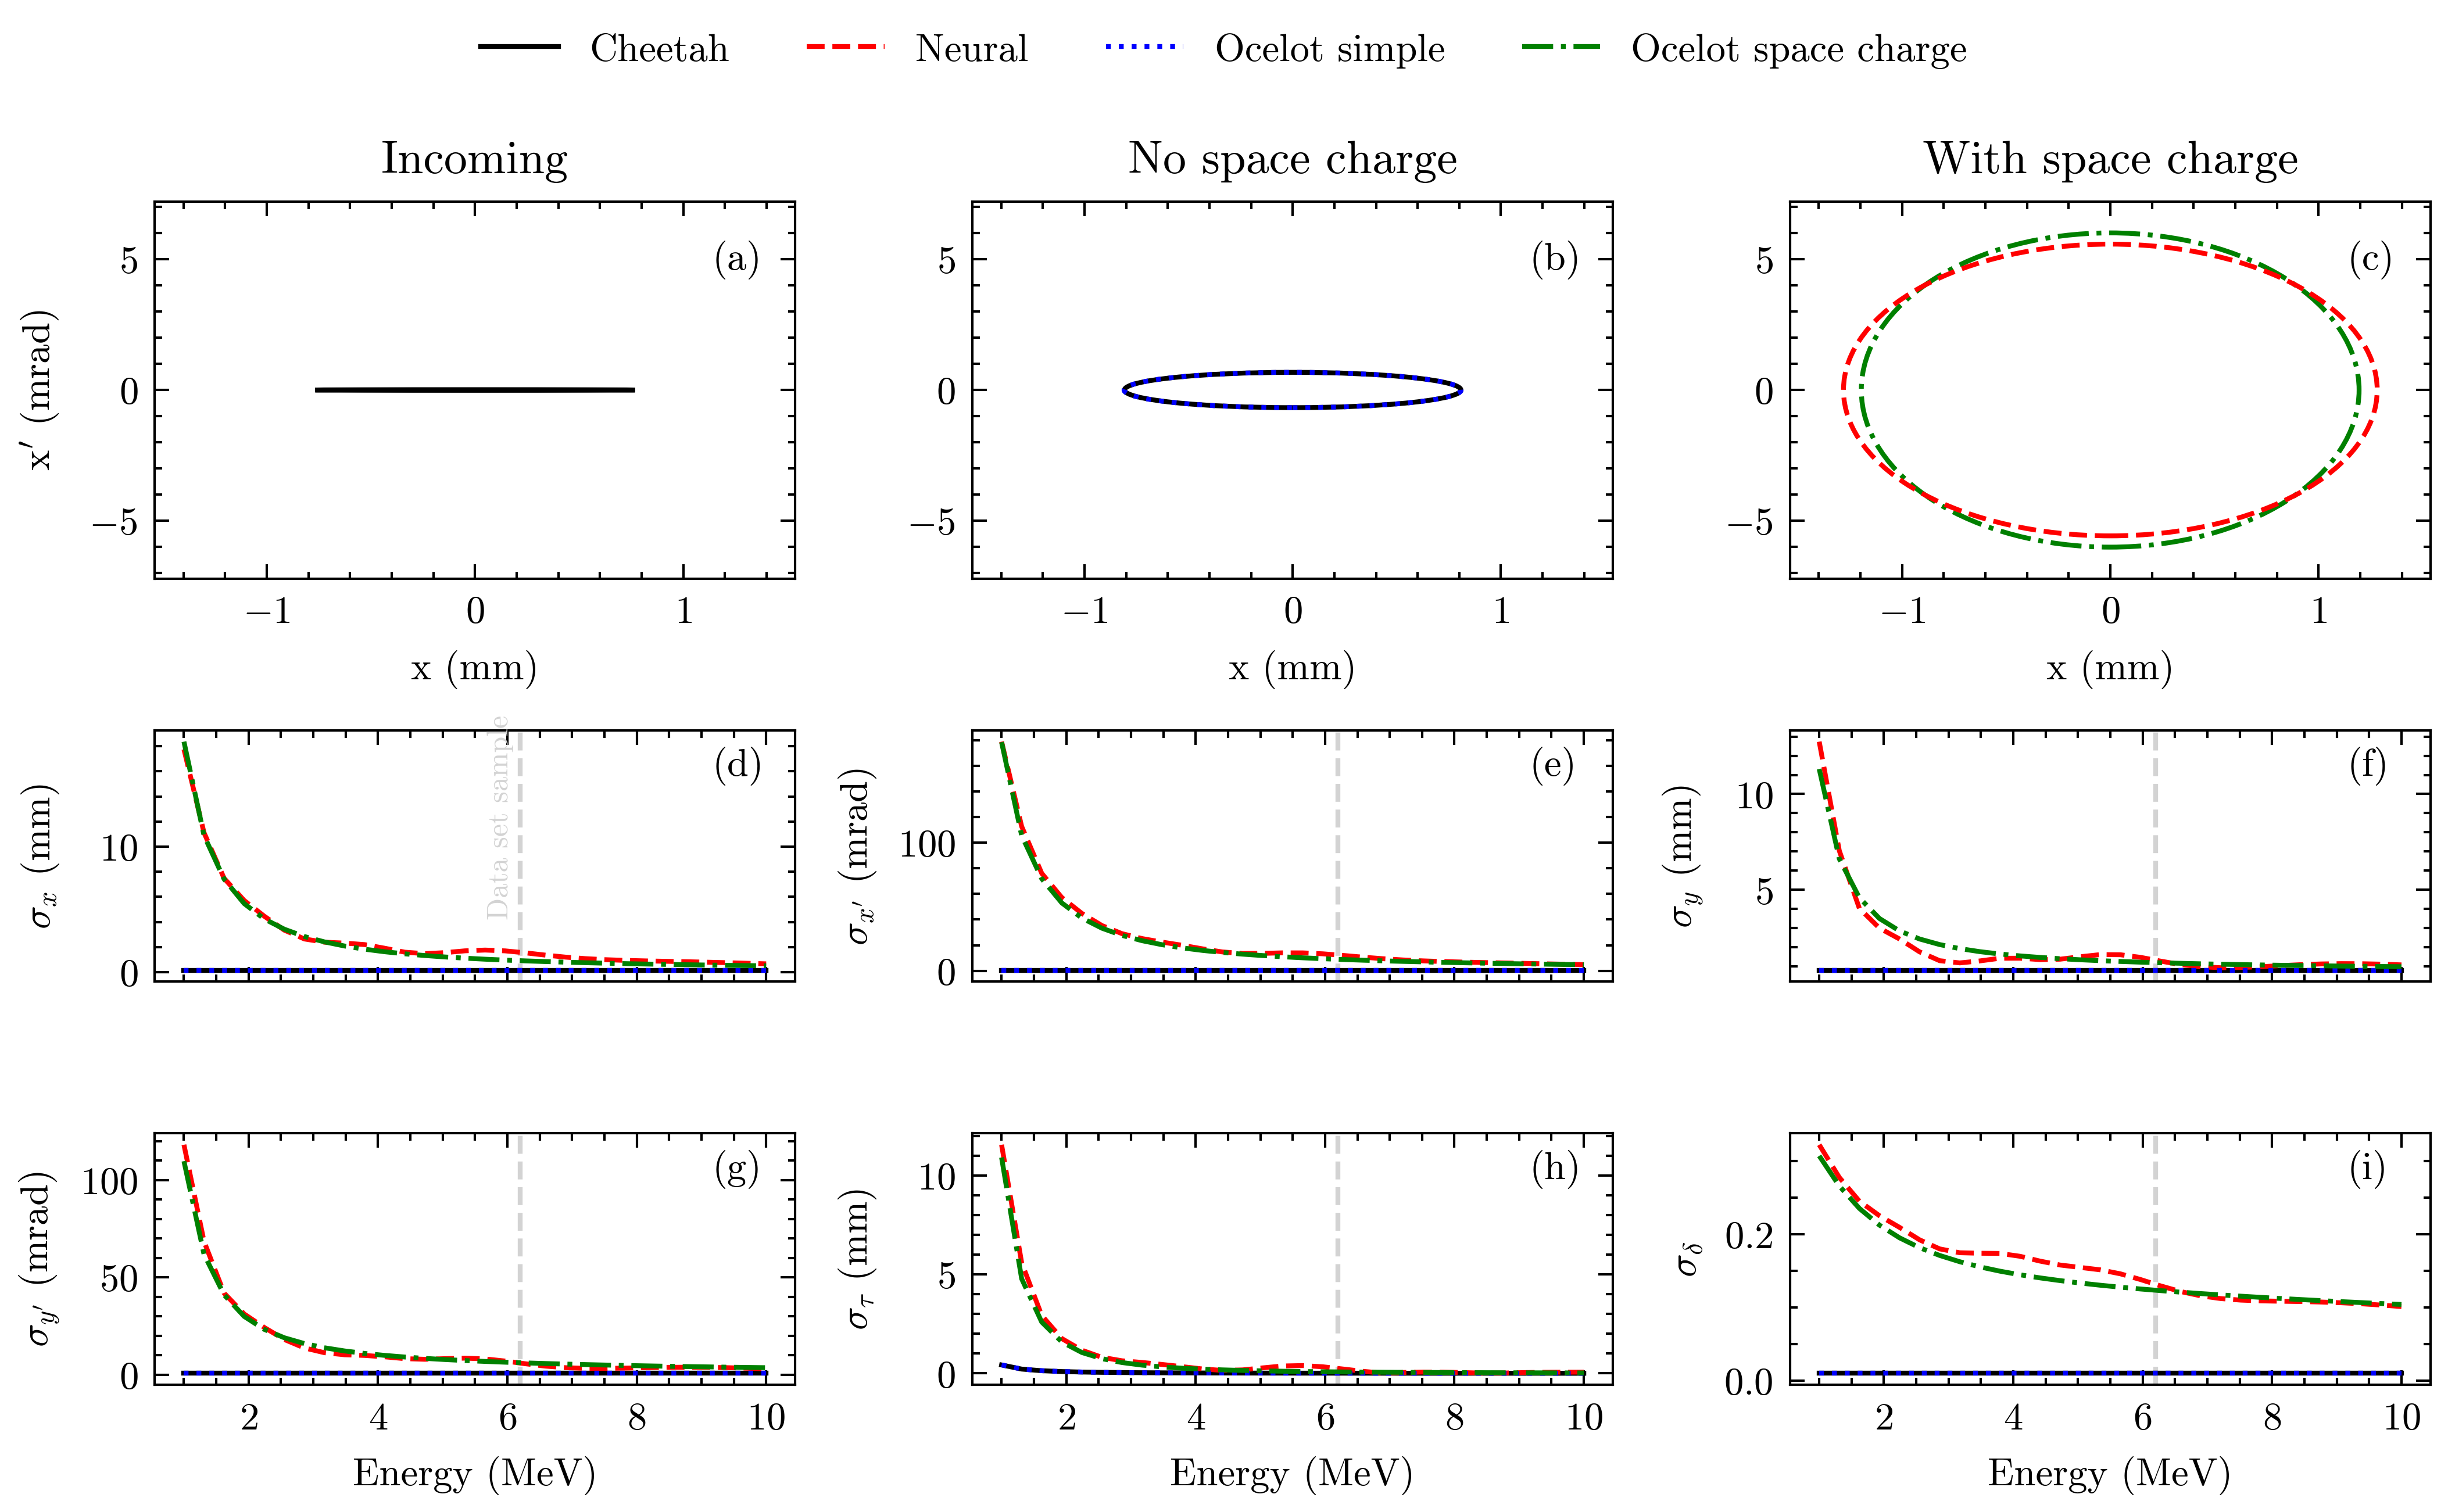

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(7.16, 2.75 * 1.5), height_ratios=[1.5, 1, 1])
prop_cycle = list(plt.rcParams["axes.prop_cycle"])
# Phase space ellipse of incoming at 6197715.5 eV as an Ellipse object
axs[0][0].add_artist(
    Ellipse(
        xy=(
            incoming_62.mu_y.detach().item() * 1e3,
            incoming_62.mu_py.detach().item() * 1e3,
        ),
        width=2 * incoming_62.sigma_y.detach().item() * 1e3,
        height=2 * incoming_62.sigma_py.detach().item() * 1e3,
        angle=0,
        fill=False,
        linewidth=1,
        **prop_cycle[0],
    )
)
widest_ellipse_x = max(
    [
        incoming_62.sigma_y.detach().item() * 1e3,
        # cheetah_outgoing_62.sigma_x.detach().item() * 1e3,
        # neural_outgoing_62.sigma_x.detach().item() * 1e3,
        # p_array_outgoing_simple_62.x().std() * 1e3,
        # p_array_outgoing_sc_62.x().std() * 1e3,
        cheetah_outgoings[17].sigma_y.detach().item() * 1e3,
        neural_outgoings[17].sigma_y.detach().item() * 1e3,
        ocelot_simple_outgoings[17].y().std() * 1e3,
        ocelot_space_charge_outgoings[17].y().std() * 1e3,
    ]
)
widest_ellipse_px = max(
    [
        incoming_62.sigma_py.detach().item() * 1e3,
        # cheetah_outgoing_62.sigma_px.detach().item() * 1e3,
        # neural_outgoing_62.sigma_px.detach().item() * 1e3,
        # p_array_outgoing_simple_62.px().std() * 1e3,
        # p_array_outgoing_sc_62.px().std() * 1e3,
        cheetah_outgoings[17].sigma_py.detach().item() * 1e3,
        neural_outgoings[17].sigma_py.detach().item() * 1e3,
        ocelot_simple_outgoings[17].py().std() * 1e3,
        ocelot_space_charge_outgoings[17].py().std() * 1e3,
    ]
)
axs[0][0].set_xlim(-widest_ellipse_x * 1.2, widest_ellipse_x * 1.2)
axs[0][0].set_ylim(-widest_ellipse_px * 1.2, widest_ellipse_px * 1.2)
axs[0][0].set_xlabel("x (mm)")
axs[0][0].set_ylabel(r"x$'$ (mrad)")
axs[0][1].add_artist(
    Ellipse(
        xy=(
            # cheetah_outgoing_62.mu_x.detach().item() * 1e3,
            # cheetah_outgoing_62.mu_px.detach().item(),
            cheetah_outgoings[17].mu_py.detach().item() * 1e3,
            cheetah_outgoings[17].mu_py.detach().item(),
        ),
        # width=2 * cheetah_outgoing_62.sigma_x.detach().item() * 1e3,
        # height=2 * cheetah_outgoing_62.sigma_px.detach().item() * 1e3,
        width=2 * cheetah_outgoings[17].sigma_y.detach().item() * 1e3,
        height=2 * cheetah_outgoings[17].sigma_py.detach().item() * 1e3,
        angle=0,
        fill=False,
        linewidth=1,
        **prop_cycle[0],
    )
)
axs[0][1].add_artist(
    Ellipse(
        xy=(
            # p_array_outgoing_simple_62.x().mean() * 1e3,
            # p_array_outgoing_simple_62.px().mean() * 1e3,
            ocelot_simple_outgoings[17].y().mean() * 1e3,
            ocelot_simple_outgoings[17].py().mean() * 1e3,
        ),
        # width=2 * p_array_outgoing_simple_62.x().std() * 1e3,
        # height=2 * p_array_outgoing_simple_62.px().std() * 1e3,
        width=2 * ocelot_simple_outgoings[17].y().std() * 1e3,
        height=2 * ocelot_simple_outgoings[17].py().std() * 1e3,
        angle=0,
        fill=False,
        linewidth=1,
        **prop_cycle[2],
    )
)
axs[0][1].set_xlabel("x (mm)")
axs[0][2].add_artist(
    Ellipse(
        xy=(
            # p_array_outgoing_sc_62.x().mean() * 1e3,
            # p_array_outgoing_sc_62.px().mean() * 1e3,
            ocelot_space_charge_outgoings[17].y().mean() * 1e3,
            ocelot_space_charge_outgoings[17].py().mean() * 1e3,
        ),
        # width=2 * p_array_outgoing_sc_62.x().std() * 1e3,
        # height=2 * p_array_outgoing_sc_62.px().std() * 1e3,
        width=2 * ocelot_space_charge_outgoings[17].y().std() * 1e3,
        height=2 * ocelot_space_charge_outgoings[17].py().std() * 1e3,
        angle=0,
        fill=False,
        linewidth=1,
        **prop_cycle[3],
    )
)
axs[0][2].add_artist(
    Ellipse(
        xy=(
            # neural_outgoing_62.mu_x.detach().item() * 1e3,
            # neural_outgoing_62.mu_px.detach().item() * 1e3,
            neural_outgoings[17].mu_y.detach().item() * 1e3,
            neural_outgoings[17].mu_py.detach().item() * 1e3,
        ),
        # width=2 * neural_outgoing_62.sigma_x.detach().item() * 1e3,
        # height=2 * neural_outgoing_62.sigma_px.detach().item() * 1e3,
        width=2 * neural_outgoings[17].sigma_y.detach().item() * 1e3,
        height=2 * neural_outgoings[17].sigma_py.detach().item() * 1e3,
        angle=0,
        fill=False,
        linewidth=1,
        **prop_cycle[1],
    )
)
axs[0][2].set_xlabel("x (mm)")
axs[1][0].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[1][0].text(
    x=6.1,
    y=0.0042 * 1e3,
    s="Data set sample",
    rotation=90,
    va="bottom",
    ha="right",
    color="lightgrey",
    fontsize=6,
)
axs[1][0].plot(
    energies * 1e-6,
    [outgoing.sigma_x.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[1][0].plot(
    energies * 1e-6,
    [outgoing.sigma_x.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[1][0].plot(
    energies * 1e-6,
    [outgoing.x().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[1][0].plot(
    energies * 1e-6,
    [outgoing.x().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[1][0].set_ylabel(r"$\sigma_x$ (mm)")
axs[1][1].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[1][1].plot(
    energies * 1e-6,
    [outgoing.sigma_px.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[1][1].plot(
    energies * 1e-6,
    [outgoing.sigma_px.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[1][1].plot(
    energies * 1e-6,
    [outgoing.px().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[1][1].plot(
    energies * 1e-6,
    [outgoing.px().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[1][1].set_ylabel(r"$\sigma_{x'}$ (mrad)")
axs[1][2].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[1][2].plot(
    energies * 1e-6,
    [outgoing.sigma_y.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[1][2].plot(
    energies * 1e-6,
    [outgoing.sigma_y.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[1][2].plot(
    energies * 1e-6,
    [outgoing.y().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[1][2].plot(
    energies * 1e-6,
    [outgoing.y().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[1][2].set_ylabel(r"$\sigma_y$ (mm)")
axs[2][0].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[2][0].plot(
    energies * 1e-6,
    [outgoing.sigma_py.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[2][0].plot(
    energies * 1e-6,
    [outgoing.sigma_py.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[2][0].plot(
    energies * 1e-6,
    [outgoing.py().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[2][0].plot(
    energies * 1e-6,
    [outgoing.py().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[2][0].set_xlabel("Energy (MeV)")
axs[2][0].set_ylabel(r"$\sigma_{y'}$ (mrad)")
axs[2][1].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[2][1].plot(
    energies * 1e-6,
    [outgoing.sigma_tau.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[2][1].plot(
    energies * 1e-6,
    [outgoing.sigma_tau.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[2][1].plot(
    energies * 1e-6,
    [outgoing.tau().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[2][1].plot(
    energies * 1e-6,
    [outgoing.tau().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[2][1].set_xlabel("Energy (MeV)")
axs[2][1].set_ylabel(r"$\sigma_{\tau}$ (mm)")
axs[2][2].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[2][2].plot(
    energies * 1e-6,
    [outgoing.sigma_p.detach().numpy() for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[2][2].plot(
    energies * 1e-6,
    [outgoing.sigma_p.detach().numpy() for outgoing in neural_outgoings],
    label="Neural",
)
axs[2][2].plot(
    energies * 1e-6,
    [outgoing.p().std() for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[2][2].plot(
    energies * 1e-6,
    [outgoing.p().std() for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[2][2].set_xlabel("Energy (MeV)")
axs[2][2].set_ylabel(r"$\sigma_{\delta}$")
fig.legend(
    *axs[1][0].get_legend_handles_labels(),
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 1.07),
    bbox_transform=fig.transFigure,
)
subfig_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
for ax, label in zip(axs.flatten(), subfig_labels):
    ax.text(x=0.87, y=0.82, s=label, transform=ax.transAxes)
for ax in axs[1]:
    ax.set_xticklabels([])
axs[0][1].set_yticklabels([])
axs[0][2].set_yticklabels([])
axs[0][1].sharex(axs[0][0])
axs[0][1].sharey(axs[0][0])
axs[0][2].sharex(axs[0][0])
axs[0][2].sharey(axs[0][0])
axs[1][1].sharex(axs[2][0])
axs[1][2].sharex(axs[2][0])
axs[2][0].sharex(axs[2][0])
axs[2][1].sharex(axs[2][0])

axs[0][0].set_title("Incoming")
axs[0][1].set_title("No space charge")
axs[0][2].set_title("With space charge")
# Add arrow from axs[0][0] to axs[0][1]
axs[0][0].annotate(
    "",
    xy=(0.5, 0.5),
    xytext=(0.5, 0.5),
    xycoords="axes fraction",
    arrowprops=dict(arrowstyle="->", color="black"),
)
plt.setp(axs[1][1].get_xticklabels(), visible=False)
plt.setp(axs[1][2].get_xticklabels(), visible=False)
# plt.setp(axs[0][1].get_yticklabels(), visible=False)
# plt.setp(axs[0][2].get_yticklabels(), visible=False)
fig.align_ylabels()
# Adjust spacing between only the two bottom rows of subplots
fig.subplots_adjust(hspace=0.05, wspace=0.05)
plt.tight_layout()
plt.savefig("energy_scan_example.pdf", bbox_inches="tight")
plt.show()

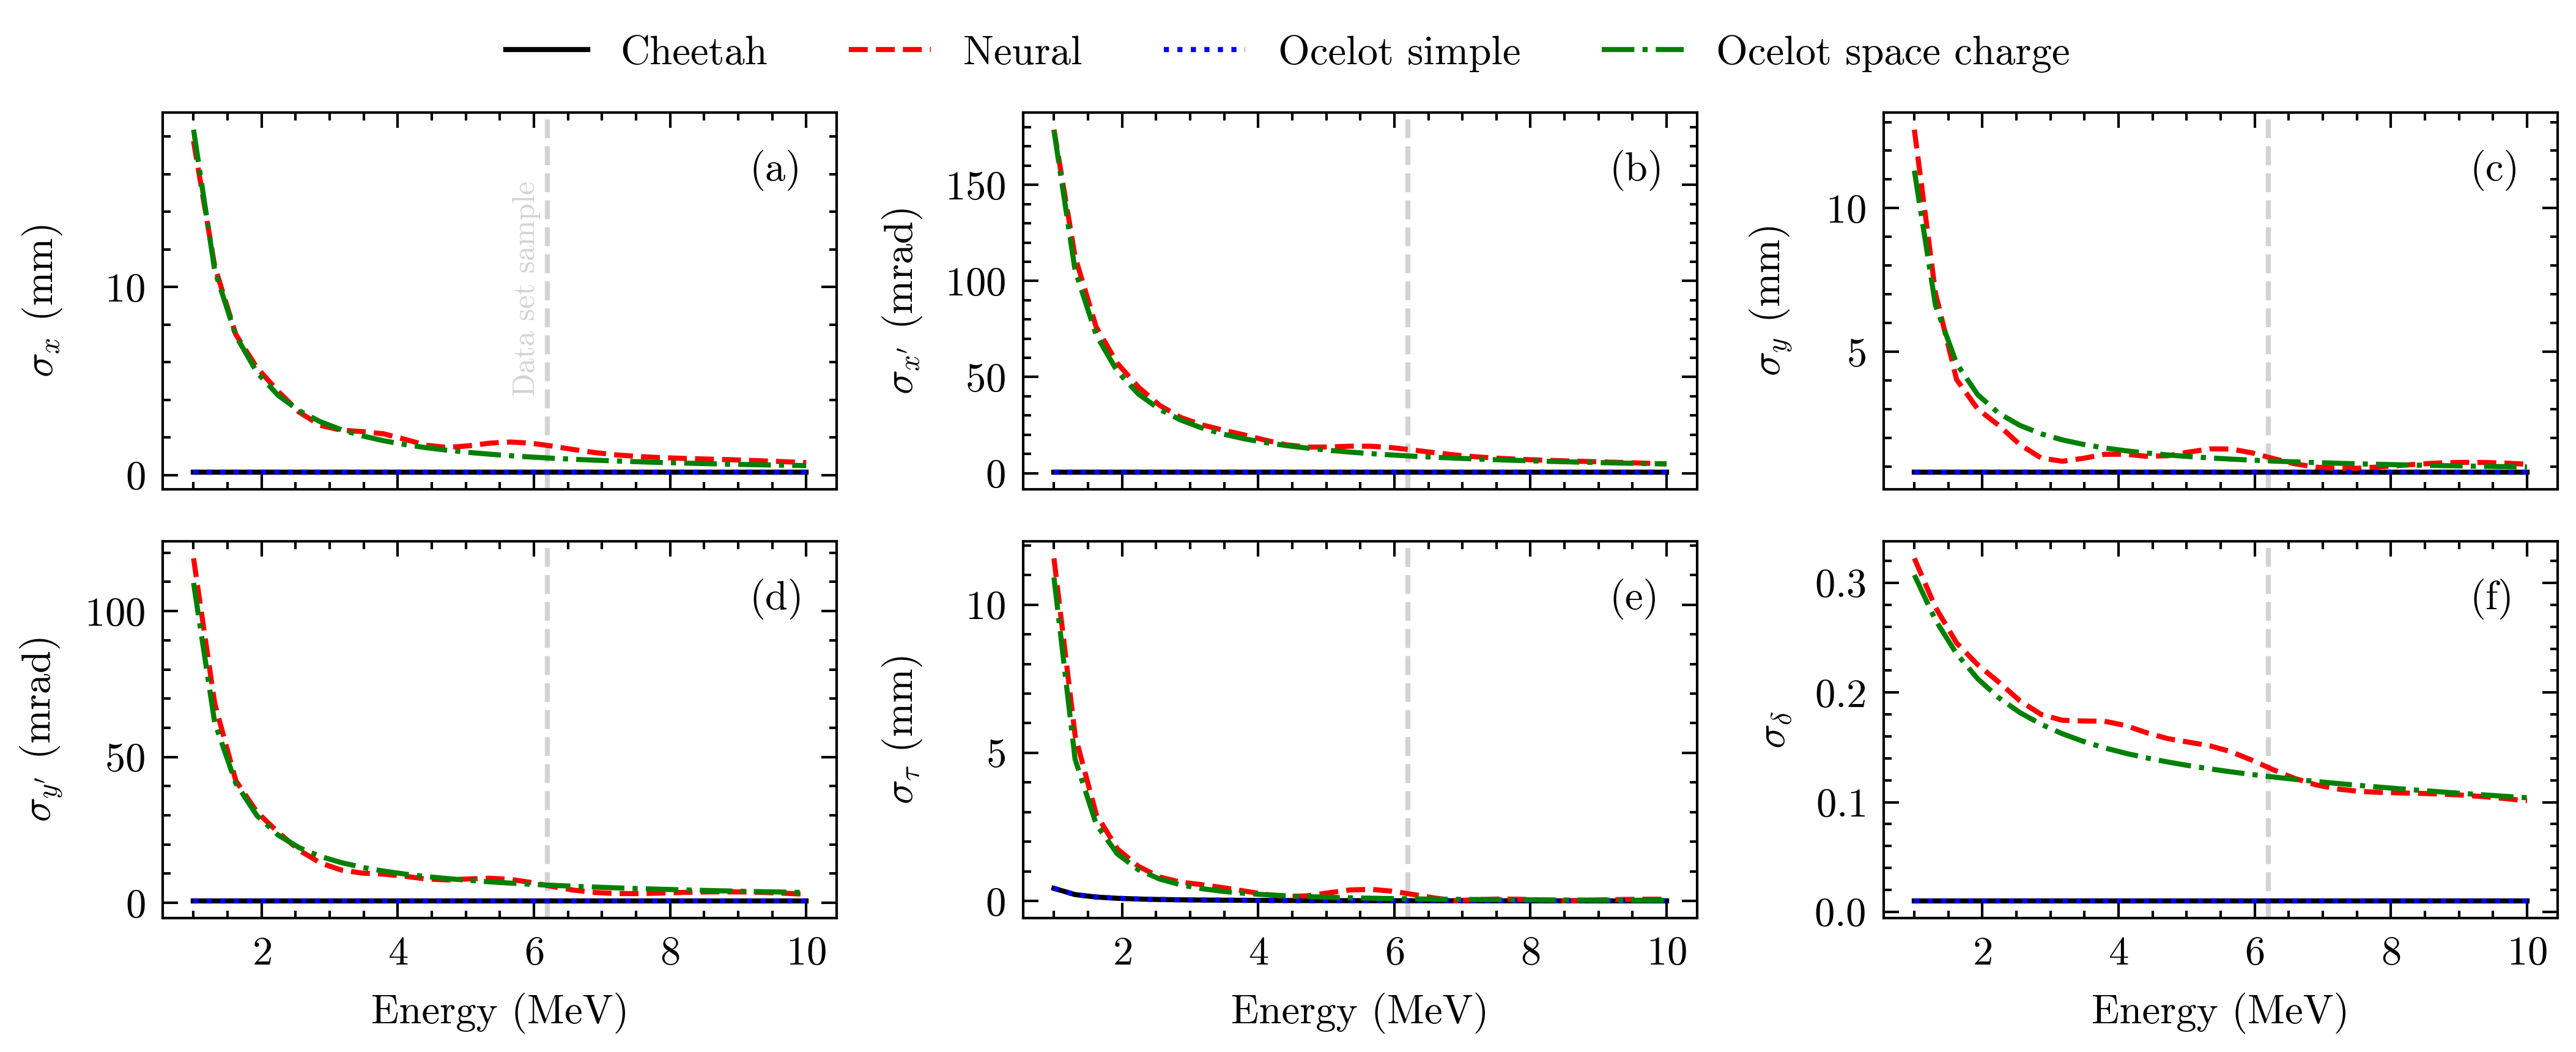

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(7.16, 2.75))
prop_cycle = list(plt.rcParams["axes.prop_cycle"])
axs[0][0].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[0][0].text(
    x=6.1,
    y=0.0042 * 1e3,
    s="Data set sample",
    rotation=90,
    va="bottom",
    ha="right",
    color="lightgrey",
    fontsize=6,
)
axs[0][0].plot(
    energies * 1e-6,
    [outgoing.sigma_x.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[0][0].plot(
    energies * 1e-6,
    [outgoing.sigma_x.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[0][0].plot(
    energies * 1e-6,
    [outgoing.x().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[0][0].plot(
    energies * 1e-6,
    [outgoing.x().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[0][0].set_ylabel(r"$\sigma_x$ (mm)")
axs[0][1].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[0][1].plot(
    energies * 1e-6,
    [outgoing.sigma_px.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[0][1].plot(
    energies * 1e-6,
    [outgoing.sigma_px.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[0][1].plot(
    energies * 1e-6,
    [outgoing.px().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[0][1].plot(
    energies * 1e-6,
    [outgoing.px().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[0][1].set_ylabel(r"$\sigma_{x'}$ (mrad)")
axs[0][2].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[0][2].plot(
    energies * 1e-6,
    [outgoing.sigma_y.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[0][2].plot(
    energies * 1e-6,
    [outgoing.sigma_y.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[0][2].plot(
    energies * 1e-6,
    [outgoing.y().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[0][2].plot(
    energies * 1e-6,
    [outgoing.y().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[0][2].set_ylabel(r"$\sigma_y$ (mm)")
axs[1][0].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[1][0].plot(
    energies * 1e-6,
    [outgoing.sigma_py.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[1][0].plot(
    energies * 1e-6,
    [outgoing.sigma_py.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[1][0].plot(
    energies * 1e-6,
    [outgoing.py().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[1][0].plot(
    energies * 1e-6,
    [outgoing.py().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[1][0].set_xlabel("Energy (MeV)")
axs[1][0].set_ylabel(r"$\sigma_{y'}$ (mrad)")
axs[1][1].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[1][1].plot(
    energies * 1e-6,
    [outgoing.sigma_tau.detach().numpy() * 1e3 for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[1][1].plot(
    energies * 1e-6,
    [outgoing.sigma_tau.detach().numpy() * 1e3 for outgoing in neural_outgoings],
    label="Neural",
)
axs[1][1].plot(
    energies * 1e-6,
    [outgoing.tau().std() * 1e3 for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[1][1].plot(
    energies * 1e-6,
    [outgoing.tau().std() * 1e3 for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[1][1].set_xlabel("Energy (MeV)")
axs[1][1].set_ylabel(r"$\sigma_{\tau}$ (mm)")
axs[1][2].axvline(6197715.5 * 1e-6, color="lightgrey", linestyle="--")
axs[1][2].plot(
    energies * 1e-6,
    [outgoing.sigma_p.detach().numpy() for outgoing in cheetah_outgoings],
    label="Cheetah",
)
axs[1][2].plot(
    energies * 1e-6,
    [outgoing.sigma_p.detach().numpy() for outgoing in neural_outgoings],
    label="Neural",
)
axs[1][2].plot(
    energies * 1e-6,
    [outgoing.p().std() for outgoing in ocelot_simple_outgoings],
    label="Ocelot simple",
)
axs[1][2].plot(
    energies * 1e-6,
    [outgoing.p().std() for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot space charge",
)
axs[1][2].set_xlabel("Energy (MeV)")
axs[1][2].set_ylabel(r"$\sigma_{\delta}$")
fig.legend(
    *axs[0][0].get_legend_handles_labels(),
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 1.07),
    bbox_transform=fig.transFigure,
)
subfig_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
for ax, label in zip(axs.flatten(), subfig_labels):
    ax.text(x=0.87, y=0.82, s=label, transform=ax.transAxes)
for ax in axs[0]:
    ax.set_xticklabels([])
axs[0][1].sharex(axs[1][0])
axs[0][2].sharex(axs[1][0])
axs[1][0].sharex(axs[1][0])
axs[1][1].sharex(axs[1][0])
plt.setp(axs[0][1].get_xticklabels(), visible=False)
plt.setp(axs[0][2].get_xticklabels(), visible=False)
# plt.setp(axs[0][1].get_yticklabels(), visible=False)
# plt.setp(axs[0][2].get_yticklabels(), visible=False)
fig.align_ylabels()
# Adjust spacing between only the two bottom rows of subplots
fig.subplots_adjust(hspace=0.05, wspace=0.05)
plt.tight_layout()
plt.savefig("energy_scan_example.pdf", bbox_inches="tight")
plt.show()

In [18]:
sigma_x_errors_cheetah = [
    np.abs(cheetah_outgoing.sigma_x.detach().numpy() - ocelot_outgoing.x().std())
    for cheetah_outgoing, ocelot_outgoing in zip(
        cheetah_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_x_errors_augmented = [
    np.abs(neural_outgoing.sigma_x.detach().numpy() - ocelot_outgoing.x().std())
    for neural_outgoing, ocelot_outgoing in zip(
        neural_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_px_errors_cheetah = [
    np.abs(cheetah_outgoing.sigma_px.detach().numpy() - ocelot_outgoing.px().std())
    for cheetah_outgoing, ocelot_outgoing in zip(
        cheetah_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_px_errors_augmented = [
    np.abs(neural_outgoing.sigma_px.detach().numpy() - ocelot_outgoing.px().std())
    for neural_outgoing, ocelot_outgoing in zip(
        neural_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_y_errors_cheetah = [
    np.abs(cheetah_outgoing.sigma_y.detach().numpy() - ocelot_outgoing.y().std())
    for cheetah_outgoing, ocelot_outgoing in zip(
        cheetah_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_y_errors_augmented = [
    np.abs(neural_outgoing.sigma_y.detach().numpy() - ocelot_outgoing.y().std())
    for neural_outgoing, ocelot_outgoing in zip(
        neural_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_py_errors_cheetah = [
    np.abs(cheetah_outgoing.sigma_py.detach().numpy() - ocelot_outgoing.py().std())
    for cheetah_outgoing, ocelot_outgoing in zip(
        cheetah_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_py_errors_augmented = [
    np.abs(neural_outgoing.sigma_py.detach().numpy() - ocelot_outgoing.py().std())
    for neural_outgoing, ocelot_outgoing in zip(
        neural_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_tau_errors_cheetah = [
    np.abs(cheetah_outgoing.sigma_tau.detach().numpy() - ocelot_outgoing.tau().std())
    for cheetah_outgoing, ocelot_outgoing in zip(
        cheetah_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_tau_errors_augmented = [
    np.abs(neural_outgoing.sigma_tau.detach().numpy() - ocelot_outgoing.tau().std())
    for neural_outgoing, ocelot_outgoing in zip(
        neural_outgoings, ocelot_space_charge_outgoings
    )
]
sigma_p_errors_cheetah = [
    np.abs(cheetah_outgoing.sigma_p.detach().numpy() - ocelot_outgoing.p().std())
    for cheetah_outgoing, ocelot_outgoing in zip(
        cheetah_outgoings, ocelot_space_charge_outgoings
    )
]

sigma_p_errors_augmented = [
    np.abs(neural_outgoing.sigma_p.detach().numpy() - ocelot_outgoing.p().std())
    for neural_outgoing, ocelot_outgoing in zip(
        neural_outgoings, ocelot_space_charge_outgoings
    )
]

_ = ic(
    np.mean(sigma_x_errors_cheetah) * 1e3,
    np.std(sigma_x_errors_cheetah) * 1e3,
    np.mean(sigma_x_errors_augmented) * 1e3,
    np.std(sigma_x_errors_augmented) * 1e3,
    "-----------------",
    np.mean(sigma_px_errors_cheetah) * 1e3,
    np.std(sigma_px_errors_cheetah) * 1e3,
    np.mean(sigma_px_errors_augmented) * 1e3,
    np.std(sigma_px_errors_augmented) * 1e3,
    "-----------------",
    np.mean(sigma_y_errors_cheetah) * 1e3,
    np.std(sigma_y_errors_cheetah) * 1e3,
    np.mean(sigma_y_errors_augmented) * 1e3,
    np.std(sigma_y_errors_augmented) * 1e3,
    "-----------------",
    np.mean(sigma_py_errors_cheetah) * 1e3,
    np.std(sigma_py_errors_cheetah) * 1e3,
    np.mean(sigma_py_errors_augmented) * 1e3,
    np.std(sigma_py_errors_augmented) * 1e3,
    "-----------------",
    np.mean(sigma_tau_errors_cheetah) * 1e3,
    np.std(sigma_tau_errors_cheetah) * 1e3,
    np.mean(sigma_tau_errors_augmented) * 1e3,
    np.std(sigma_tau_errors_augmented) * 1e3,
    "-----------------",
    np.mean(sigma_p_errors_cheetah),
    np.std(sigma_p_errors_cheetah),
    np.mean(sigma_p_errors_augmented),
    np.std(sigma_p_errors_augmented),
)

ic| np.mean(sigma_x_errors_cheetah) * 1e3: np.float64(2.3894434540012734)
    np.std(sigma_x_errors_cheetah) * 1e3: np.float64(3.7178853804596024)
    np.mean(sigma_x_errors_augmented) * 1e3: np.float64(0.30489012820268296)
    np.std(sigma_x_errors_augmented) * 1e3: np.float64(0.1871793422519233)
    "-----------------": '-----------------'
    np.mean(sigma_px_errors_cheetah) * 1e3: np.float64(24.250451311027895)
    np.std(sigma_px_errors_cheetah) * 1e3: np.float64(36.07253672777132)
    np.mean(sigma_px_errors_augmented) * 1e3: np.float64(1.84321503757845)
    np.std(sigma_px_errors_augmented) * 1e3: np.float64(1.6194703608132797)
    "-----------------": '-----------------'
    np.mean(sigma_y_errors_cheetah) * 1e3: np.float64(1.271862193204882)
    np.std(sigma_y_errors_cheetah) * 1e3: np.float64(2.0968921543630445)
    np.mean(sigma_y_errors_augmented) * 1e3: np.float64(0.30033020609423683)
    np.std(sigma_y_errors_augmented) * 1e3: np.float64(0.3030839066310927)
    "---------

In [19]:
p_array_incoming = generate_parray(
    sigma_x=dataset_train_raw[sample_idx][0][0][0].numpy(),
    sigma_px=dataset_train_raw[sample_idx][0][0][1].numpy(),
    sigma_y=dataset_train_raw[sample_idx][0][0][2].numpy(),
    sigma_py=dataset_train_raw[sample_idx][0][0][3].numpy(),
    sigma_tau=dataset_train_raw[sample_idx][0][0][4].numpy(),
    sigma_p=dataset_train_raw[sample_idx][0][0][5].numpy(),
    charge=dataset_train_raw[sample_idx][0][0][6].numpy(),
    nparticles=100_000,
    energy=dataset_train_raw[sample_idx][0][0][7].numpy() * 1e-9,  # GeV
    chirp=0.0,
)
p_array_incoming.q_array = (
    np.full_like(p_array_incoming.q_array, 1e-9) / p_array_incoming.size()
)

# The marker is needed for space charge to work
ocelot_cell = [ocelot.Quadrupole(l=0.12, k1=7.2), ocelot.Marker("dummy")]

In [20]:
%%timeit

method = {"global": ocelot.SecondTM}
method = {}
lattice = ocelot.MagneticLattice(ocelot_cell, method=method)

space_charge = ocelot.SpaceCharge()
space_charge.nmesh_xyz = [63, 63, 63]
space_charge.step = 1

navigator = ocelot.Navigator(lattice)
navigator.add_physics_proc(space_charge, ocelot_cell[0], ocelot_cell[-1])
navigator.unit_step = 0.02

p_array = deepcopy(p_array_incoming)
_, p_array_outgoing = ocelot.track(lattice, p_array, navigator)

ocelot_space_charge_outgoings.append(p_array_outgoing)

z = 0.12 / 0.12. Applied: SpaceCharge856 ms ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
incoming = cheetah.ParameterBeam.from_parameters(
    sigma_x=dataset_train_raw[sample_idx][0][0][0],
    sigma_px=dataset_train_raw[sample_idx][0][0][1],
    sigma_y=dataset_train_raw[sample_idx][0][0][2],
    sigma_py=dataset_train_raw[sample_idx][0][0][3],
    sigma_tau=dataset_train_raw[sample_idx][0][0][4],
    sigma_p=dataset_train_raw[sample_idx][0][0][5],
    total_charge=torch.tensor(1e-9),
    energy=dataset_train_raw[sample_idx][0][0][7],
)

In [22]:
%%timeit
neural_outgoing = neural_quadrupole.track(incoming)

573 μs ± 24.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [23]:
%%timeit
cheetah_outgoing = cheetah_quadrupole.track(incoming)

221 μs ± 9.48 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
# Incoming directly from Cheetah
incoming = cheetah.ParameterBeam.from_parameters(
    sigma_x=dataset_train_raw[sample_idx][0][0][0],
    sigma_px=dataset_train_raw[sample_idx][0][0][1],
    sigma_y=dataset_train_raw[sample_idx][0][0][2],
    sigma_py=dataset_train_raw[sample_idx][0][0][3],
    sigma_tau=dataset_train_raw[sample_idx][0][0][4],
    sigma_p=dataset_train_raw[sample_idx][0][0][5],
    total_charge=torch.tensor(1e-9),
    energy=torch.tensor(1e6),
)
incoming_parameters = torch.stack(
    [
        incoming.sigma_x,
        incoming.sigma_px,
        incoming.sigma_y,
        incoming.sigma_py,
        incoming.sigma_tau,
        incoming.sigma_p,
        incoming.total_charge,
        incoming.energy,
    ]
)

transformed_incoming_parameters = (
    torch.log(incoming_parameters) - neural_quadrupole._incoming_scaler_mean
) / neural_quadrupole._incoming_scaler_scale
print("Direct incoming parameters: ", incoming_parameters)
print("Transformed incoming parameters: ", transformed_incoming_parameters)

Direct incoming parameters:  tensor([1.4949e-04, 5.1053e-04, 7.6779e-04, 1.2811e-05, 1.4415e-06, 1.0026e-02,
        1.0000e-09, 1.0000e+06])
Transformed incoming parameters:  tensor([ 0.2654,  1.2230,  1.4894, -1.5400, -0.9939,  0.8304,  1.2063, -1.9078])


In [25]:
# Incoming from Ocelot
p_array_incoming = ocelot.generate_parray(
    sigma_x=dataset_train_raw[sample_idx][0][0][0].numpy(),
    sigma_px=dataset_train_raw[sample_idx][0][0][1].numpy(),
    sigma_y=dataset_train_raw[sample_idx][0][0][2].numpy(),
    sigma_py=dataset_train_raw[sample_idx][0][0][3].numpy(),
    sigma_tau=dataset_train_raw[sample_idx][0][0][4].numpy(),
    sigma_p=dataset_train_raw[sample_idx][0][0][5].numpy(),
    charge=1e-9,
    nparticles=100_000,
    energy=1e-3,  # GeV
    chirp=0.0,
)
incoming_ocelot = cheetah.ParameterBeam.from_ocelot(p_array_incoming)
incoming_parameters_ocelot = torch.stack(
    [
        incoming_ocelot.sigma_x,
        incoming_ocelot.sigma_px,
        incoming_ocelot.sigma_y,
        incoming_ocelot.sigma_py,
        incoming_ocelot.sigma_tau,
        incoming_ocelot.sigma_p,
        incoming_ocelot.total_charge,
        incoming_ocelot.energy,
    ]
)
transformed_incoming_parameters_ocelot = (
    torch.log(incoming_parameters_ocelot) - neural_quadrupole._incoming_scaler_mean
) / neural_quadrupole._incoming_scaler_scale
print("Ocelot incoming parameters: ", incoming_parameters_ocelot)
print(
    "Transformed ocelot incoming parameters: ", transformed_incoming_parameters_ocelot
)

Ocelot incoming parameters:  tensor([1.4940e-04, 5.0983e-04, 7.6775e-04, 1.2785e-05, 1.4381e-06, 1.0029e-02,
        1.0000e-09, 1.0000e+06])
Transformed ocelot incoming parameters:  tensor([ 0.2650,  1.2219,  1.4894, -1.5415, -0.9951,  0.9726,  1.2063, -1.9078])


In [26]:
for outgoing in ocelot_space_charge_outgoings:
    print(outgoing.rparticles)

[[ 0.016976   -0.03636862  0.00136241 ... -0.01993829  0.02386651
  -0.01367138]
 [ 0.16523507 -0.35404205  0.01325653 ... -0.19399738  0.2324297
  -0.13326513]
 [ 0.00280402 -0.00351552 -0.01332041 ... -0.01161758 -0.01365874
   0.00465865]
 [ 0.02777056 -0.03491218 -0.12250078 ... -0.11516712 -0.13514765
   0.04616578]
 [-0.02020665 -0.00740918 -0.00088019 ... -0.01713381  0.00394475
  -0.00704711]
 [ 0.57115813  0.20962668  0.02541766 ...  0.48407827 -0.11088962
   0.19967865]]
[[ 1.03170880e-02 -2.10524714e-02  8.27457136e-04 ... -1.22549207e-02
   1.38914438e-02 -8.15774105e-03]
 [ 1.00291073e-01 -2.04965715e-01  8.15298893e-03 ... -1.19130495e-01
   1.35285098e-01 -7.94558565e-02]
 [ 1.68660927e-03 -1.97405050e-03 -8.13085632e-03 ... -6.80678716e-03
  -7.69780085e-03  2.60397718e-03]
 [ 1.63429651e-02 -1.92041296e-02 -6.98921549e-02 ... -6.60454003e-02
  -7.41687739e-02  2.50991325e-02]
 [-8.29010894e-03 -2.65801694e-03 -3.35985849e-04 ... -6.83937019e-03
   2.22118217e-03 -3.078

In [27]:
neural_outgoings

[ParameterBeam(mu=tensor([0., 0., 0., 0., 0., 0., 1.]), cov=tensor([[0.0003, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0319, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0139, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1039, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
        grad_fn=<CopySlices>), energy=tensor(1000000.), total_charge=tensor(1.0000e-09), s=tensor(0.), species=Species(name='electron', num_elementary_charges=tensor(-1), mass_eV=tensor(510998.9375))),
 ParameterBeam(mu=tensor([0., 0., 0., 0., 0., 0., 1.]), cov=tensor([[1.2344e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 1.2680e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],


In [28]:
p_array_direct = astraBeam2particleArray("ACHIP_EA1_2021.1351.001")
cheetah_direct = cheetah.ParameterBeam.from_astra("ACHIP_EA1_2021.1351.001")
cheetah_converted = cheetah.ParameterBeam.from_ocelot(p_array_direct)

Astra to Ocelot: charge =  5.000000000001694e-13  C
Astra to Ocelot: particles number =  100000
Astra to Ocelot: energy =  0.10731590244355117  GeV
Astra to Ocelot: s pos =  13.50890653269  m


In [29]:
p_array_incoming.x().std(), cheetah_direct.sigma_x.item(), cheetah_converted.sigma_x.item()

(np.float64(0.00014940195286023916),
 0.00017489789752289653,
 0.00017489789752289653)

In [30]:
p_array_incoming.y().std(), cheetah_direct.sigma_y.item(), cheetah_converted.sigma_y.item()

(np.float64(0.0007677421131314067),
 0.00017519544053357095,
 0.00017519544053357095)

In [31]:
p_array_incoming.px().std(), cheetah_direct.sigma_px.item(), cheetah_converted.sigma_px.item()

(np.float64(0.0005098263539504549),
 3.679402198031312e-06,
 3.679402198031312e-06)

In [32]:
num_samples = 100

# Compute Ocelot beams
ocelot_beams = []
cheetah_beams = []
neural_beams = []
for i in range(num_samples):
    # Generate Ocelot beam
    p_array_incoming = generate_parray(
        sigma_x=dataset_train_raw[i][0][0][0].numpy(),
        sigma_px=dataset_train_raw[i][0][0][1].numpy(),
        sigma_y=dataset_train_raw[i][0][0][2].numpy(),
        sigma_py=dataset_train_raw[i][0][0][3].numpy(),
        sigma_tau=dataset_train_raw[i][0][0][4].numpy(),
        sigma_p=dataset_train_raw[i][0][0][5].numpy(),
        charge=dataset_train_raw[i][0][0][6].numpy(),
        nparticles=100_000,
        energy=dataset_train_raw[i][0][0][7].numpy() * 1e-9,  # GeV
        chirp=0.0,
    )

    ocelot_cell = [
        ocelot.Quadrupole(
            l=dataset_train_raw[i][0][1][0], k1=dataset_train_raw[i][0][1][1]
        ),
        ocelot.Marker("dummy"),
    ]

    method = {"global": ocelot.SecondTM}
    lattice = ocelot.MagneticLattice(ocelot_cell, method=method)

    space_charge = ocelot.SpaceCharge()
    space_charge.nmesh_xyz = [63, 63, 63]
    space_charge.step = 1

    navigator = ocelot.Navigator(lattice)
    navigator.add_physics_proc(space_charge, ocelot_cell[0], ocelot_cell[-1])
    navigator.unit_step = 0.02

    _, p_array_outgoing = ocelot.track(lattice, deepcopy(p_array_incoming), navigator)

    ocelot_beams.append(p_array_outgoing)

    # Generate Cheetah beam
    # cheetah_incoming = cheetah.ParameterBeam.from_ocelot(p_array_incoming)
    cheetah_incoming = cheetah.ParameterBeam.from_parameters(
        sigma_x=dataset_train_raw[sample_idx][0][0][0],
        sigma_px=dataset_train_raw[sample_idx][0][0][1],
        sigma_y=dataset_train_raw[sample_idx][0][0][2],
        sigma_py=dataset_train_raw[sample_idx][0][0][3],
        sigma_tau=dataset_train_raw[sample_idx][0][0][4],
        sigma_p=dataset_train_raw[sample_idx][0][0][5],
        total_charge=dataset_train_raw[sample_idx][0][0][6],
        energy=dataset_train_raw[sample_idx][0][0][7],
    )
    cheetah_quadrupole = cheetah.Quadrupole(
        length=dataset_train_raw[i][0][1][0],
        k1=dataset_train_raw[i][0][1][1],
    )
    cheetah_outgoing = cheetah_quadrupole.track(cheetah_incoming)

    cheetah_beams.append(cheetah_outgoing)

    # Generate neural Cheetah beam
    # neural_incoming = cheetah.ParameterBeam.from_ocelot(p_array_incoming)
    neural_incoming = cheetah.ParameterBeam.from_parameters(
        sigma_x=dataset_train_raw[i][0][0][0],
        sigma_px=dataset_train_raw[i][0][0][1],
        sigma_y=dataset_train_raw[i][0][0][2],
        sigma_py=dataset_train_raw[i][0][0][3],
        sigma_tau=dataset_train_raw[i][0][0][4],
        sigma_p=dataset_train_raw[i][0][0][5],
        total_charge=dataset_train_raw[i][0][0][6],
        energy=dataset_train_raw[i][0][0][7],
    )
    neural_quadrupole = NNSpaceChargeQuadrupole(
        length=dataset_train_raw[i][0][1][0],
        k1=dataset_train_raw[i][0][1][1],
    )
    neural_outgoing = neural_quadrupole.track(neural_incoming)

    neural_beams.append(neural_outgoing)

z = 0.34801146388053894 / 0.34801146388053894. Applied: SpaceChargege

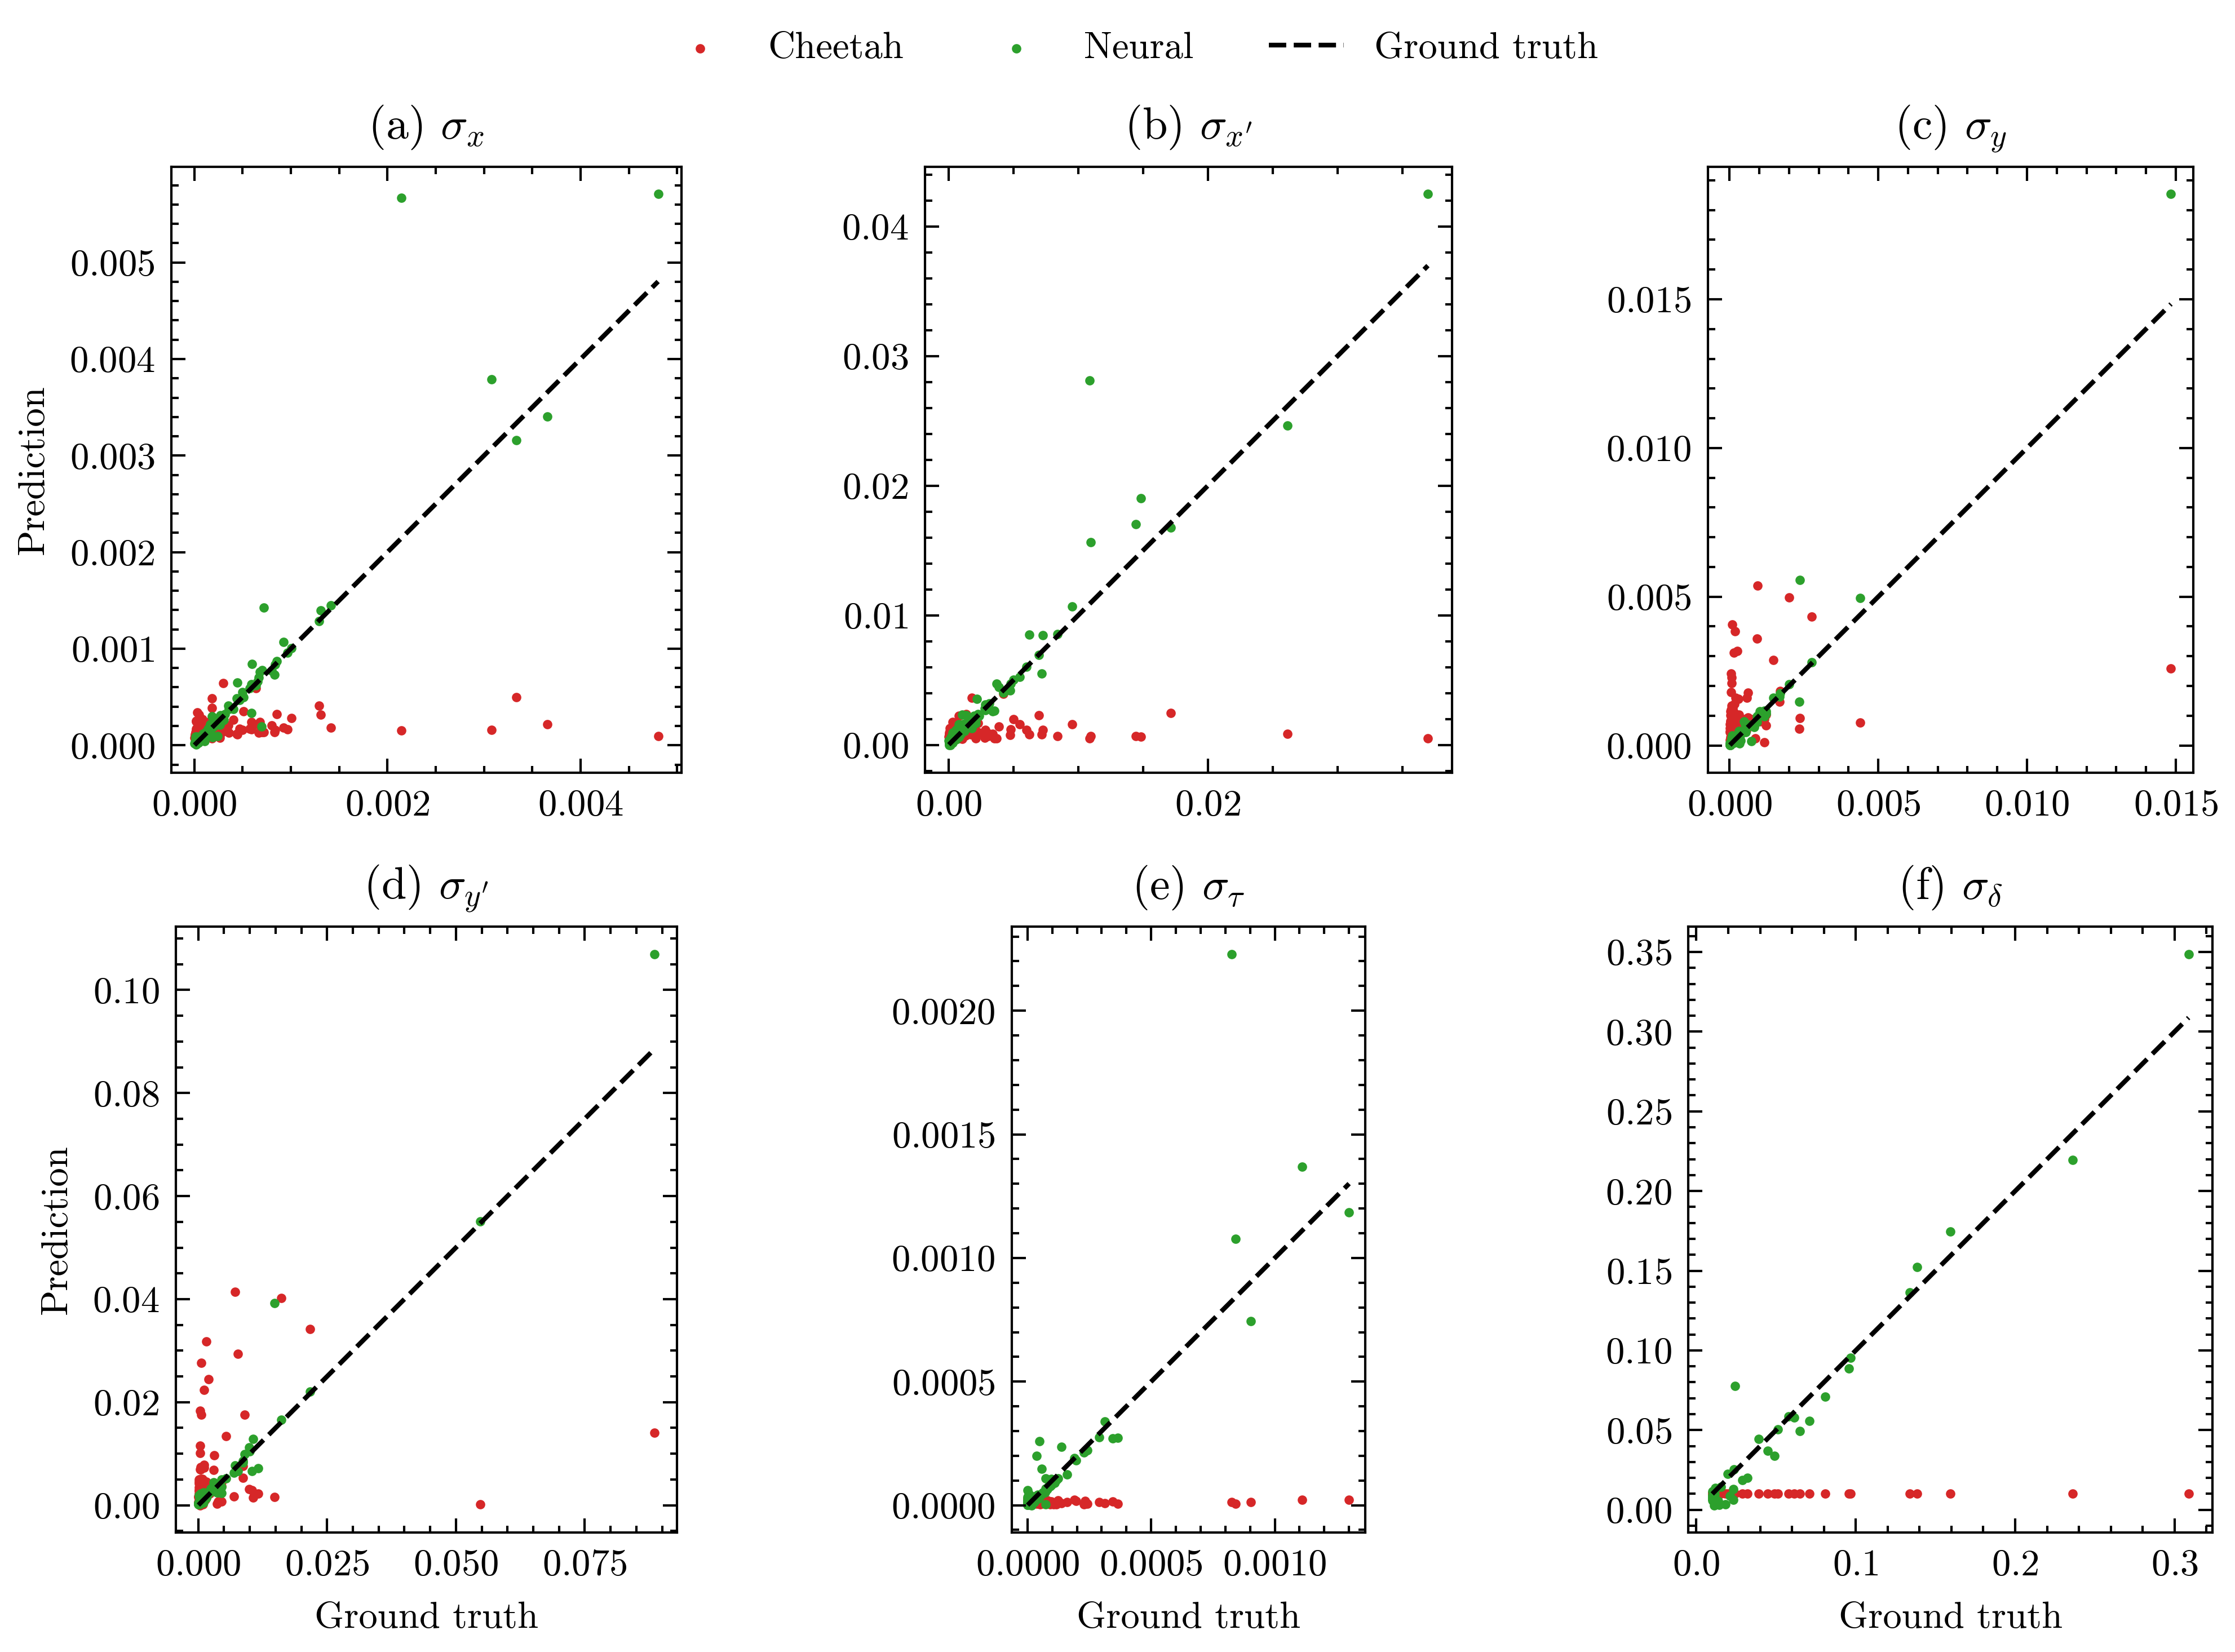

In [33]:
plt.figure(figsize=(7.16, 4.77))

plt.subplot(2, 3, 1)
plt.scatter(
    [ocelot_beam.x().std() for ocelot_beam in ocelot_beams],
    [cheetah_beam.sigma_x.item() for cheetah_beam in cheetah_beams],
    s=1,
    c="tab:red",
    label="Cheetah",
)
plt.scatter(
    [ocelot_beam.x().std() for ocelot_beam in ocelot_beams],
    [neural_beam.sigma_x.item() for neural_beam in neural_beams],
    s=1,
    c="tab:green",
    label="Neural",
)
plt.plot(
    [
        min([ocelot_beam.x().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.x().std() for ocelot_beam in ocelot_beams]),
    ],
    [
        min([ocelot_beam.x().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.x().std() for ocelot_beam in ocelot_beams]),
    ],
    ls="--",
    label="Ground truth",
)
plt.ylabel("Prediction")
plt.title(r"(a) $\sigma_x$")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 2)
plt.scatter(
    [ocelot_beam.px().std() for ocelot_beam in ocelot_beams],
    [cheetah_beam.sigma_px.item() for cheetah_beam in cheetah_beams],
    s=1,
    c="tab:red",
    label="Cheetah",
)
plt.scatter(
    [ocelot_beam.px().std() for ocelot_beam in ocelot_beams],
    [neural_beam.sigma_px.item() for neural_beam in neural_beams],
    s=1,
    c="tab:green",
    label="Neural",
)
plt.plot(
    [
        min([ocelot_beam.px().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.px().std() for ocelot_beam in ocelot_beams]),
    ],
    [
        min([ocelot_beam.px().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.px().std() for ocelot_beam in ocelot_beams]),
    ],
    ls="--",
    label="Ground truth",
)
plt.title(r"(b) $\sigma_{x'}$")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 3)
plt.scatter(
    [ocelot_beam.y().std() for ocelot_beam in ocelot_beams],
    [cheetah_beam.sigma_y.item() for cheetah_beam in cheetah_beams],
    s=1,
    c="tab:red",
    label="Cheetah",
)
plt.scatter(
    [ocelot_beam.y().std() for ocelot_beam in ocelot_beams],
    [neural_beam.sigma_y.item() for neural_beam in neural_beams],
    s=1,
    c="tab:green",
    label="Neural",
)
plt.plot(
    [
        min([ocelot_beam.y().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.y().std() for ocelot_beam in ocelot_beams]),
    ],
    [
        min([ocelot_beam.y().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.y().std() for ocelot_beam in ocelot_beams]),
    ],
    ls="--",
    label="Ground truth",
)
plt.title(r"(c) $\sigma_y$")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 4)
plt.scatter(
    [ocelot_beam.py().std() for ocelot_beam in ocelot_beams],
    [cheetah_beam.sigma_py.item() for cheetah_beam in cheetah_beams],
    s=1,
    c="tab:red",
    label="Cheetah",
)
plt.scatter(
    [ocelot_beam.py().std() for ocelot_beam in ocelot_beams],
    [neural_beam.sigma_py.item() for neural_beam in neural_beams],
    s=1,
    c="tab:green",
    label="Neural",
)
plt.plot(
    [
        min([ocelot_beam.py().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.py().std() for ocelot_beam in ocelot_beams]),
    ],
    [
        min([ocelot_beam.py().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.py().std() for ocelot_beam in ocelot_beams]),
    ],
    ls="--",
    label="Ground truth",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title(r"(d) $\sigma_{y'}$")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 5)
plt.scatter(
    [ocelot_beam.tau().std() for ocelot_beam in ocelot_beams],
    [cheetah_beam.sigma_tau.item() for cheetah_beam in cheetah_beams],
    s=1,
    c="tab:red",
    label="Cheetah",
)
plt.scatter(
    [ocelot_beam.tau().std() for ocelot_beam in ocelot_beams],
    [neural_beam.sigma_tau.item() for neural_beam in neural_beams],
    s=1,
    c="tab:green",
    label="Neural",
)
plt.plot(
    [
        min([ocelot_beam.tau().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.tau().std() for ocelot_beam in ocelot_beams]),
    ],
    [
        min([ocelot_beam.tau().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.tau().std() for ocelot_beam in ocelot_beams]),
    ],
    ls="--",
    label="Ground truth",
)
plt.xlabel("Ground truth")
plt.title(r"(e) $\sigma_\tau$")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 6)
plt.scatter(
    [ocelot_beam.p().std() for ocelot_beam in ocelot_beams],
    [cheetah_beam.sigma_p.item() for cheetah_beam in cheetah_beams],
    s=1,
    c="tab:red",
    label="Cheetah",
)
plt.scatter(
    [ocelot_beam.p().std() for ocelot_beam in ocelot_beams],
    [neural_beam.sigma_p.item() for neural_beam in neural_beams],
    s=1,
    c="tab:green",
    label="Neural",
)
plt.plot(
    [
        min([ocelot_beam.p().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.p().std() for ocelot_beam in ocelot_beams]),
    ],
    [
        min([ocelot_beam.p().std() for ocelot_beam in ocelot_beams]),
        max([ocelot_beam.p().std() for ocelot_beam in ocelot_beams]),
    ],
    ls="--",
    label="Ground truth",
)
plt.xlabel("Ground truth")
plt.title(r"(f) $\sigma_{\delta}$")
plt.gca().set_aspect("equal", adjustable="box")
fig = plt.gcf()
ax = plt.gca()
fig.legend(
    *ax.get_legend_handles_labels(),
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 1.04),
    bbox_transform=fig.transFigure,
)
plt.tight_layout()
plt.savefig("correlations.pdf", bbox_inches="tight")
plt.show()